In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [60]:
# 함수 init
def count_store(df):
    # 2006~2024년 구간의 인허가 연도별 카운트
    permit_count = df[df['인허가년도'].between(2006, 2024)].groupby('인허가년도').size()

    # 누적 카운트 (각 년도별로 그 이전 년도까지의 합을 포함)
    cumulative_permit_count = permit_count.cumsum()

    # 폐업년도 처리: 2006년 이후로 폐업한 사업장만 해당하며, 폐업년도가 있는 데이터만 필터링
    closure_count = df[df['폐업연도'].notna() & df['폐업연도'].between(2006, 2024)]

    # 폐업연도에 해당하는 사업장 개수를 각 연도별로 빼기
    closure_count = closure_count.groupby('폐업연도').size()

    # 2006년을 0으로 추가
    closure_count = pd.concat([pd.Series({2006: 0}), closure_count])

    # 정렬 (연도 순서대로)
    closure_count = closure_count.sort_index()

    # 폐업된 사업장을 누적 카운트에서 제외
    final_count = cumulative_permit_count - closure_count
    
    # 누적 카운트, 년도별 카운트, 폐점 카운트, 최종 카운트(누적카운트-폐점카운트)
    return cumulative_permit_count, permit_count, closure_count, final_count

In [2]:
import os
os.chdir("/Users/shinjh/Desktop/likelion/mid_project/dataset_life_infra")

dataset_list = [x for x in os.listdir() if 'dataset_life_infra' in x]

In [3]:
dataset_list = [x for x in os.listdir() if 'dataset_life_infra' in x]

In [4]:
data = [x for x in dataset_list if '일반음식점_인' in x]
print(data)

['dataset_life_infra_일산_일반음식점_인허가일자포함.csv', 'dataset_life_infra_분당_일반음식점_인허가일자포함.csv']


In [5]:
data_bundang = pd.read_csv(next((x for x in data if '분당' in x)))
data_ilsan = pd.read_csv(next((x for x in data if '일산' in x)))

# 음식점 점포수

## 분당처리
- 2006년 이전 데이터 -> 전부 2006년도로 치환 후 누적합산 처리

In [58]:
# 인허가년도, 폐업연도 처리 부분
data_bundang['인허가년도'] = data_bundang['인허가일자'].apply(lambda x: int(x.split("-")[0]))
data_bundang['폐업연도'] = data_bundang['폐업일자'].apply(lambda x: int(x.split("-")[0]) if pd.notnull(x) else None)

# 필터링 및 데이터 처리
filter_1_bundang = data_bundang[data_bundang['폐업연도'].isna()]
filter_2_bundang = data_bundang[data_bundang['폐업연도'].notna() & (data_bundang['폐업연도'] > 2006)]

# filter_2_bundang에서 폐업연도를 Int64로 변환
filter_2_bundang.loc[:, '폐업연도'] = filter_2_bundang['폐업연도'].astype('Int64')

# 필터링된 데이터 결합
filtered_after_2006_bundang = pd.concat([filter_1_bundang, filter_2_bundang]).reset_index(drop=True)

# 데이터 복사
filtered_data_bundang = filtered_after_2006_bundang.copy()

# 인허가년도 변경 처리 (2006년 이전은 2006으로 설정)
filtered_data_bundang.loc[:, '인허가년도'] = filtered_data_bundang['인허가년도'].apply(lambda x: 2006 if x < 2006 else x)

# 필요한 열만 선택
filtered_data_bundang = filtered_data_bundang[["사업장명", "소재지도로명주소", "소재지지번주소", "위도", "경도", "영업상태명", "인허가일자", "폐업일자", "업태구분명정보", "인허가년도", "폐업연도"]]


## 일산 처리

In [59]:
# 인허가년도, 폐업연도 처리 부분
data_ilsan['인허가년도'] = data_ilsan['인허가일자'].apply(lambda x: int(x.split("-")[0]))
data_ilsan['폐업연도'] = data_ilsan['폐업일자'].apply(lambda x: int(x.split("-")[0]) if pd.notnull(x) else None)

# 필터링 및 데이터 처리
filter_1_ilsan = data_ilsan[data_ilsan['폐업연도'].isna()]
filter_2_ilsan = data_ilsan[data_ilsan['폐업연도'].notna() & (data_ilsan['폐업연도'] > 2006)]

# filter_2_ilsan에서 폐업연도를 Int64로 변환
filter_2_ilsan.loc[:, '폐업연도'] = filter_2_ilsan['폐업연도'].astype('Int64')

# 필터링된 데이터 결합
filtered_after_2006_ilsan = pd.concat([filter_1_ilsan, filter_2_ilsan]).reset_index(drop=True)

# 데이터 복사
filtered_data_ilsan = filtered_after_2006_ilsan.copy()

# 인허가년도 변경 처리 (2006년 이전은 2006으로 설정)
filtered_data_ilsan.loc[:, '인허가년도'] = filtered_data_ilsan['인허가년도'].apply(lambda x: 2006 if x < 2006 else x)

# 필요한 열만 선택
filtered_data_ilsan = filtered_data_ilsan[["사업장명", "소재지도로명주소", "소재지지번주소", "위도", "경도", "영업상태명", "인허가일자", "폐업일자", "업태구분명정보", "인허가년도", "폐업연도"]]


In [ ]:
cumulative_permit_bundang_count, permit_bundang_count, closure_bundang_count, final_bundang_count = count_store(filtered_data_bundang)

# 증감률 시작일자 0으로 변경
change_rate_bundang = permit_bundang_count - closure_bundang_count
change_rate_bundang.iloc[0] = 0 

# 데이터 프레임화
count_df_bundang = pd.DataFrame([cumulative_permit_bundang_count, closure_bundang_count, change_rate_bundang,final_bundang_count]).T.reset_index()
count_df_bundang.columns = ['년도','인허가갯수', '폐업갯수', '증감률','년도별갯수']

In [62]:
cumulative_permit_ilsan_count, permit_ilsan_count, closure_ilsan_count, final_ilsan_count = count_store(filtered_data_ilsan)

# 증감률 시작일자 0으로 변경
change_rate_ilsan = permit_ilsan_count - closure_ilsan_count
change_rate_ilsan.iloc[0] = 0 

count_df_ilsan = pd.DataFrame([cumulative_permit_ilsan_count, closure_ilsan_count, change_rate_ilsan,final_ilsan_count]).T.reset_index()
count_df_ilsan.columns = ['년도','인허가갯수', '폐업갯수', '증감률','년도별갯수']
    

In [57]:
count_df_bundang

,년도,인허가갯수,폐업갯수,증감률,년도별갯수
0,2006,3467,0,0,3467
1,2007,3877,386,24,3491
2,2008,4230,474,-121,3756
3,2009,4628,306,92,4322
4,2010,5104,335,141,4769
5,2011,5607,338,165,5269
6,2012,6142,360,175,5782
7,2013,6639,270,227,6369
8,2014,7166,345,182,6821
9,2015,7719,399,154,7320


In [64]:
count_df_ilsan

,년도,인허가갯수,폐업갯수,증감률,년도별갯수
0,2006,5245,0,0,5245
1,2007,6098,642,211,5456
2,2008,6680,575,7,6105
3,2009,7356,850,-174,6506
4,2010,8057,564,137,7493
5,2011,8715,636,22,8079
6,2012,9274,470,89,8804
7,2013,9909,531,104,9378
8,2014,10542,482,151,10060
9,2015,11153,458,153,10695


In [35]:
import matplotlib.pyplot as plt
from matplotlib import rc  ### 이 줄과


# 다른 MacOS 폰트 경로 (AppleGothic)
rc('font', family='AppleGothic') 

# 마이너스 기호 문제 해결하기
plt.rcParams['axes.unicode_minus'] = False



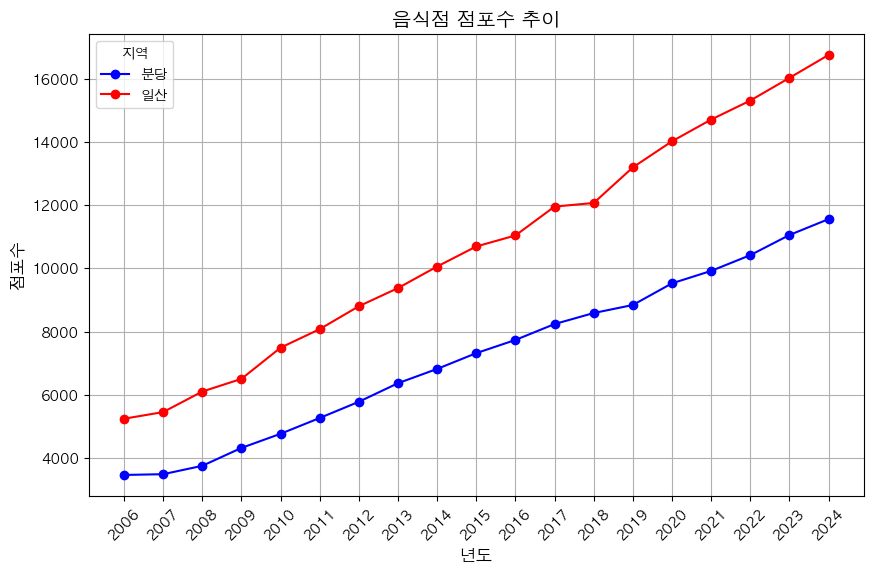

In [67]:
## 점포수
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_bundang['년도'], count_df_bundang['년도별갯수'], marker='o', color='b', linestyle='-')
plt.plot(count_df_ilsan['년도'], count_df_ilsan['년도별갯수'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('음식점 점포수 추이', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_bundang['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

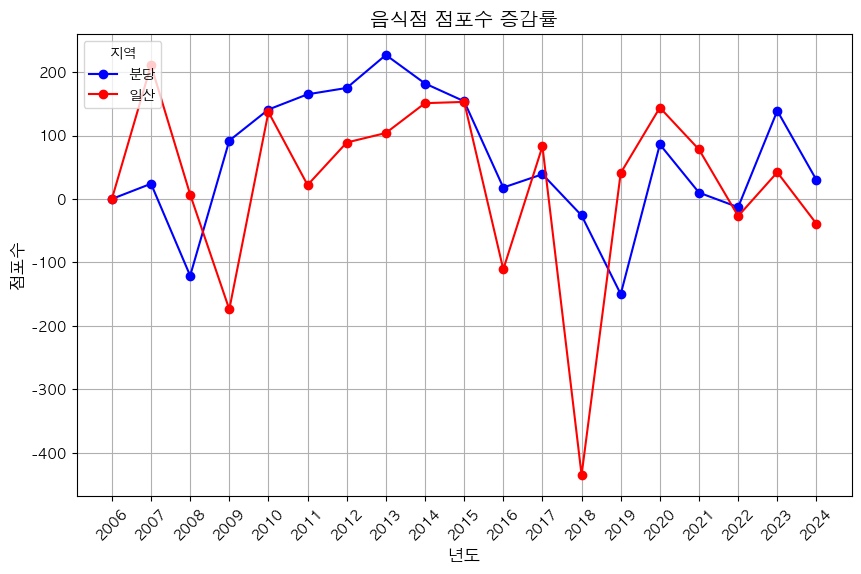

In [71]:
## 점포수
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_bundang['년도'], count_df_bundang['증감률'], marker='o', color='b', linestyle='-')
plt.plot(count_df_ilsan['년도'], count_df_ilsan['증감률'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('음식점 점포수 증감률', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_bundang['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

# 학교

In [72]:
data = [x for x in dataset_list if '학교' in x]
print(data)

['dataset_life_infra_일산_학교.csv', 'dataset_life_infra_분당_학교.csv']


In [73]:
data_bundang = pd.read_csv(next((x for x in data if '분당' in x)))
data_ilsan = pd.read_csv(next((x for x in data if '일산' in x)))

In [74]:
data_bundang.head()

,Unnamed: 0,학교명,학교급구분,설립일자,설립형태,운영상태,소재지지번주소,소재지도로명주소,시도교육청명,위도,경도
0,0,판교대장초등학교,초등학교,2021-06-01,공립,운영,경기도 성남시 분당구 대장동 155,경기도 성남시 분당구 판교대장로5길 71,경기도교육청,37.368259,127.069717
1,1,수내초등학교,초등학교,1993-01-11,공립,운영,경기도 성남시 분당구 수내동 81,경기도 성남시 분당구 백현로243번길 12,경기도교육청,37.367766,127.124663
2,2,산운초등학교,초등학교,2009-03-01,공립,운영,경기도 성남시 분당구 운중동 927,경기도 성남시 분당구 판교원로117번길 11,경기도교육청,37.389753,127.079026
3,3,서현초등학교,초등학교,1991-09-01,공립,운영,경기도 성남시 분당구 서현동 87-1,경기도 성남시 분당구 중앙공원로39번길 12,경기도교육청,37.382576,127.128550
4,4,성남송현초등학교,초등학교,2009-03-01,공립,운영,경기도 성남시 분당구 삼평동 710,경기도 성남시 분당구 동판교로 258,경기도교육청,37.405452,127.116346
